In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [2]:
output_dir = 'output'

# Step 6 Exploration

In [108]:
# Initialize counters
total_libraries = 0
total_library_instances = 0

# Walk through the output directory to count libraries and library instances
for subdir, dirs, files in os.walk(output_dir):
    if subdir == output_dir:  # If we're in the base output directory
        total_libraries = len(dirs)  # Count the number of subdirectories (libraries)
    else:
        total_library_instances += len(dirs)  # Count the versions (library instances)

(total_libraries, total_library_instances)

(26, 249)

In [109]:
deps = []
direct_deps = []
trans_deps = []
vuln_deps = []
direct_vuln_deps = []
trans_vuln_deps = []
rel_intervals = []
lag_deps = []
dep_types_collector = []

In [110]:
all_deps = []
deployed_deps = []
dev_only_vuln_ratios = []
dev_only_deps = []

In [111]:
# Initialize lists to store data
cvss_scores = []
exposure_counts = []

In [112]:
def calculate_statistics(data_list):
    if not data_list:  # Check if the list is empty
        return [np.nan] * 7  # Return NaNs if there's no data
    return [
        np.mean(data_list),  # Mean
        np.std(data_list),   # Standard deviation
        np.min(data_list),   # Min
        np.max(data_list),   # Max
        np.percentile(data_list, 25),  # 25th percentile
        np.median(data_list),  # Median (50th percentile)
        np.percentile(data_list, 75)   # 75th percentile
    ]

In [113]:
def process_json_file_step6(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
        
        # 计算总依赖数量和部署后依赖数量
        total_deps_count = len(data['dependencies'])
        deployed_deps_count = sum(1 for details in data['dependencies'].values() 
                          if 'development-only' not in details.get('dependencyTypes', []))        
        # 计算开发时唯一依赖的漏洞比例
        dev_only_vuln_count = sum(1 for _, details in data['dependencies'].items() if 'development' in details.get('dependencyTypes', []) and details['highestCvssScore'] != -1)
        if total_deps_count > 0:
            dev_only_vuln_ratio = dev_only_vuln_count / total_deps_count
        else:
            dev_only_vuln_ratio = 0
        
        # 添加数据到列表中
        all_deps.append(total_deps_count)
        deployed_deps.append(deployed_deps_count)
        dev_only_vuln_ratios.append(dev_only_vuln_ratio)
        dev_only_deps.append(dev_only_vuln_count)
        
        # Process dependencies
        lagging_info = {dep: details['intervals'] for dep, details in data['dependencies'].items()}
        vulnerabilities = {dep: details for dep, details in data['dependencies'].items() if details['highestCvssScore'] != -1}
        
        # Counters for different types of dependencies using list comprehensions
        total_deps = len(data['dependencies'])
        total_direct = sum(1 for details in data['dependencies'].values() if details['intervals'] != -1)
        total_trans = total_deps - total_direct
        total_vuln = len(vulnerabilities)
        total_direct_vuln = sum(1 for dep, details in vulnerabilities.items() if details['intervals'] != -1)
        total_trans_vuln = total_vuln - total_direct_vuln
        total_lagging = sum(1 for details in data['dependencies'].values() if 'lagging' in details.get('dependencyTypes', []))
        release_intervals = [details['intervals'] for details in data['dependencies'].values() if details['intervals'] != -1]
        
        # Extract CVSS scores and exposure counts
        for dep, details in data['dependencies'].items():
            dep_list = details.get('dependencyTypes', [])
                # Check if the sub-list is empty, which means it's a 'normal' dependency
            if not dep_list:
                dep_types_collector.append(['normal'])
            else:
                # If not empty, extend the collector list with the types in the sub-list
                dep_types_collector.append(dep_list)
            
            if details['highestCvssScore'] != -1:  # Only consider dependencies with a CVSS score
                cvss_scores.append(details['highestCvssScore'])
                # Get the exposure count from vulnerabilityExposure, defaulting to 0 if not present
                exposure_count = data['vulnerabilityExposure'].get(dep, 0)
                exposure_counts.append(exposure_count)

        # Append counts to the respective lists
        deps.append(total_deps)
        direct_deps.append(total_direct)
        trans_deps.append(total_trans)
        vuln_deps.append(total_vuln)
        direct_vuln_deps.append(total_direct_vuln)
        trans_vuln_deps.append(total_trans_vuln)
        lag_deps.append(total_lagging)  # Add lagging dependencies to the list
        rel_intervals.extend(release_intervals)  # Extend the list with new intervals

In [114]:
# Clear any previous data from all lists
deps.clear()
direct_deps.clear()
trans_deps.clear()
vuln_deps.clear()
direct_vuln_deps.clear()
trans_vuln_deps.clear()
rel_intervals.clear()
lag_deps.clear()

In [115]:
# Walk through the output directory and process each step6_output.json file
for subdir, dirs, files in os.walk(output_dir):
    for file in files:
        if file == 'step6_output.json':
            file_path = os.path.join(subdir, file)  # Construct the full file path
            process_json_file_step6(file_path)  # Process the JSON file

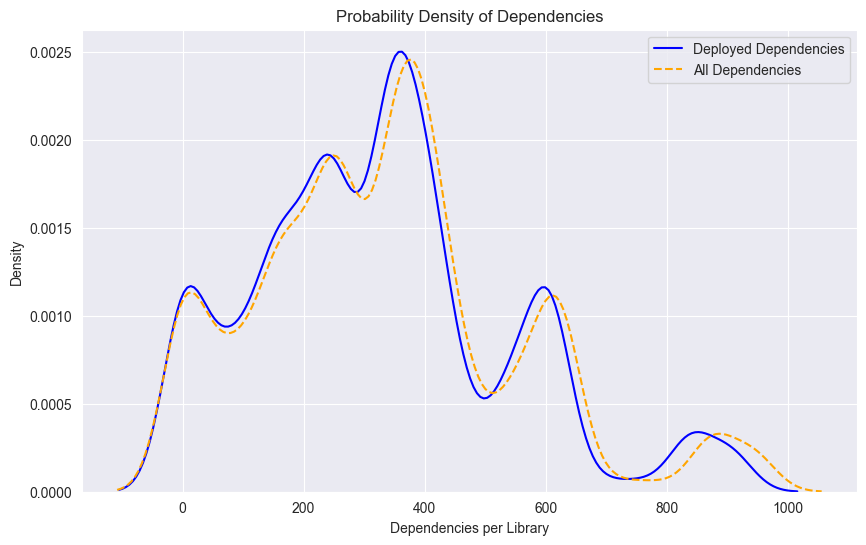

In [116]:
plt.figure(figsize=(10, 6))
sns.kdeplot(deployed_deps, color="blue", label='Deployed Dependencies', bw_adjust=0.5)
sns.kdeplot(all_deps, color="orange", linestyle="--", label='All Dependencies', bw_adjust=0.5)
plt.title('Probability Density of Dependencies')
plt.xlabel('Dependencies per Library')
plt.ylabel('Density')
plt.legend()
plt.show()

In [117]:
all_stats = {
    '#deps': calculate_statistics(deps),
    '#direct': calculate_statistics(direct_deps),
    '#trans': calculate_statistics(trans_deps),
    '#vuln deps': calculate_statistics(vuln_deps),
    '#direct vuln': calculate_statistics(direct_vuln_deps),
    '#trans vuln': calculate_statistics(trans_vuln_deps),
    'rel intervals (days)': calculate_statistics(rel_intervals)
}
all_stats

{'#deps': [335.9775784753363, 216.35710896666706, 2, 946, 175.5, 339.0, 424.0],
 '#direct': [14.174887892376681, 9.446136983508056, 2, 45, 7.0, 13.0, 18.0],
 '#trans': [321.80269058295966,
  209.37169855115505,
  0,
  901,
  169.0,
  334.0,
  409.0],
 '#vuln deps': [7.5291479820627805, 7.6085745051568505, 0, 27, 1.0, 5.0, 14.5],
 '#direct vuln': [0.5112107623318386, 0.9272215429227025, 0, 4, 0.0, 0.0, 1.0],
 '#trans vuln': [7.017937219730942, 7.184914518753759, 0, 27, 0.0, 5.0, 13.0],
 'rel intervals (days)': [186.97057893071812,
  279.88312869347993,
  1,
  2107,
  21.0,
  77.0,
  241.0]}

In [118]:
# Create a DataFrame from the statistics
stats_df = pd.DataFrame.from_dict(all_stats, orient='index', columns=['μ (Mu)', 'σ (Sigma)', 'min', 'max', 'Q25%', 'Q50%', 'Q75%'])

# Since we only had a single file and the statistics are not varying, the standard deviation and percentiles are not meaningful
# We will display the DataFrame as is for now
stats_df.reset_index(inplace=True)
stats_df.rename(columns={'index': 'Metric'}, inplace=True)

stats_df

,Metric,μ (Mu),σ (Sigma),min,max,Q25%,Q50%,Q75%
0,#deps,335.977578,216.357109,2,946,175.5,339.0,424.0
1,#direct,14.174888,9.446137,2,45,7.0,13.0,18.0
2,#trans,321.802691,209.371699,0,901,169.0,334.0,409.0
3,#vuln deps,7.529148,7.608575,0,27,1.0,5.0,14.5
4,#direct vuln,0.511211,0.927222,0,4,0.0,0.0,1.0
5,#trans vuln,7.017937,7.184915,0,27,0.0,5.0,13.0
6,rel intervals (days),186.970579,279.883129,1,2107,21.0,77.0,241.0


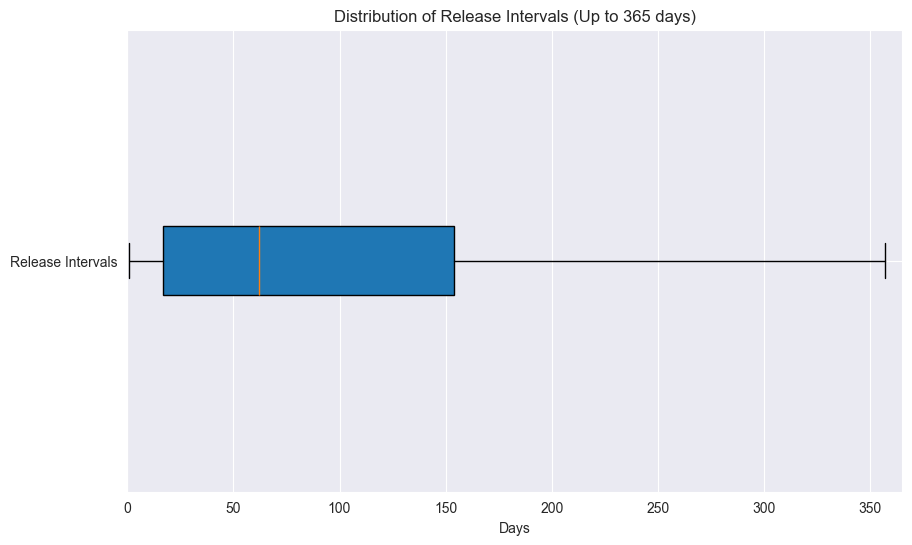

In [119]:
# Filter out release intervals that are more than 365 days
filtered_intervals = [interval for interval in rel_intervals if interval <= 365]

# Plot the box plot for the filtered release intervals
if filtered_intervals:
    plt.figure(figsize=(10, 6))
    plt.boxplot(filtered_intervals, vert=False, patch_artist=True)
    plt.title('Distribution of Release Intervals (Up to 365 days)')
    plt.xlabel('Days')
    plt.yticks([1], ['Release Intervals'])
    plt.xlim(0, 365)  # Set x-axis limit to 365 days for better visibility of the distribution
    plt.show()
else:
    print("No release intervals up to 365 days to display.")

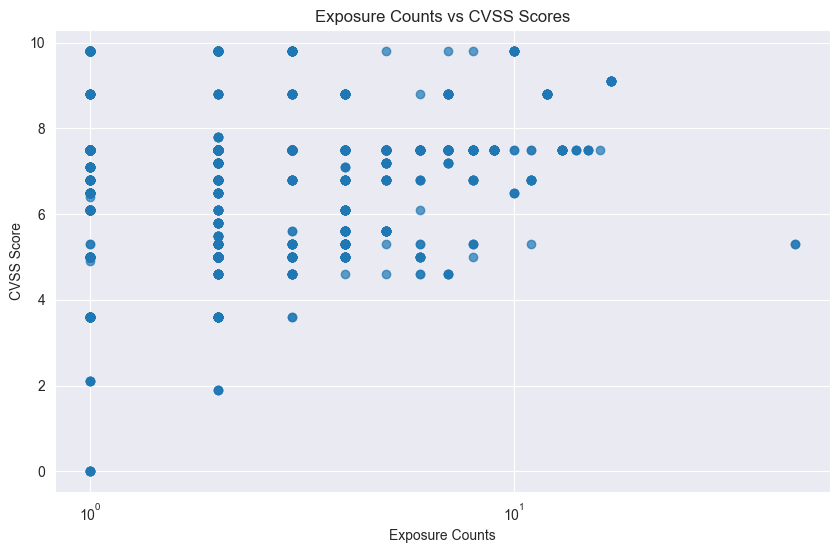

In [120]:
# Plot the scatter plot of exposure counts vs CVSS scores
plt.figure(figsize=(10, 6))
plt.scatter(exposure_counts, cvss_scores, alpha=0.7)
plt.title('Exposure Counts vs CVSS Scores')
plt.xlabel('Exposure Counts')
plt.ylabel('CVSS Score')
plt.xscale('log')  # Use logarithmic scale if exposure counts vary widely
plt.show()

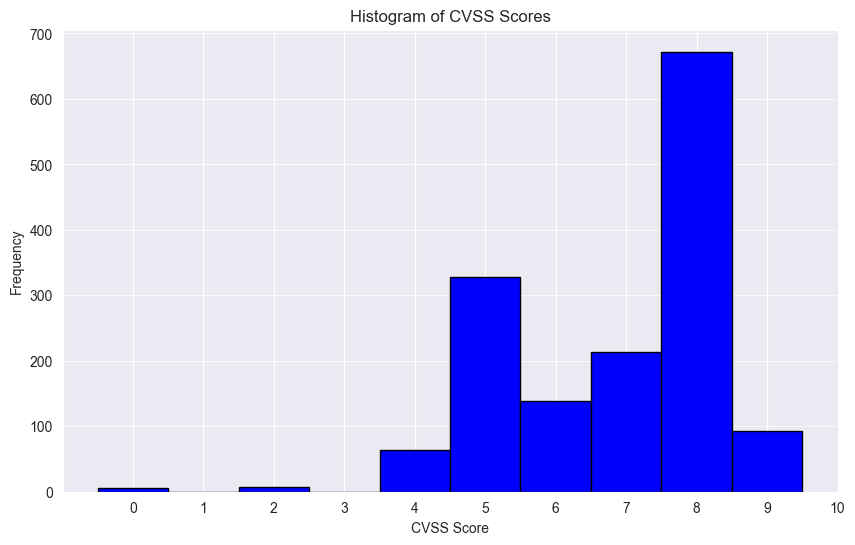

In [121]:
# Analysis 1: Histogram of CVSS Scores
def plot_cvss_histogram(cvss_scores):
    plt.figure(figsize=(10, 6))
    plt.hist(cvss_scores, bins=np.arange(11) - 0.5, color='blue', edgecolor='black')
    plt.title('Histogram of CVSS Scores')
    plt.xlabel('CVSS Score')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 11))
    plt.grid(axis='y', alpha=0.75)
    plt.show()
plot_cvss_histogram(cvss_scores)

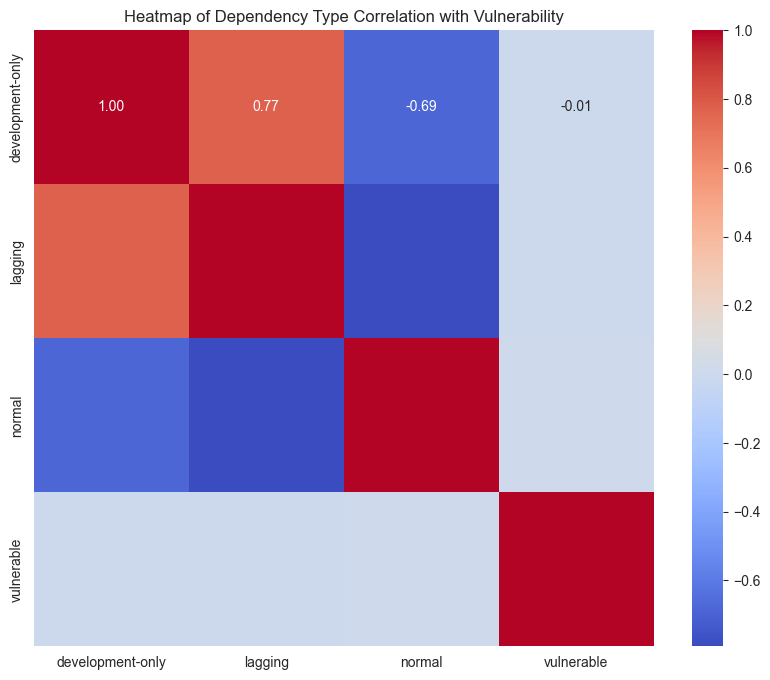

In [122]:
# All unique dependency types
all_types = list(set([t for sublist in dep_types_collector for t in sublist]))
all_types.sort()

# Initialize a matrix with zeros
dep_matrix = pd.DataFrame(0, index=np.arange(len(dep_types_collector)), columns=all_types)

# Fill the matrix with 1 where the dependency type is present
for i, types in enumerate(dep_types_collector):
    for t in types:
        dep_matrix.loc[i, t] = 1

# Add a 'vulnerable' column for the presence of vulnerabilities
# This is a simplified binary indicator for vulnerability, actual implementation may vary
dep_matrix['vulnerable'] = np.random.choice([0, 1], size=len(dep_types_collector))

# Generate the correlation matrix
correlation_matrix = dep_matrix.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Dependency Type Correlation with Vulnerability')
plt.show()

# Step 5 Exploration

In [16]:
# Function to normalize severity levels by combining them and handling case differences
def normalize_severity(severity):
    # Convert to lowercase and map 'moderate' to 'medium'
    severity = severity.lower()
    if severity == 'moderate':
        return 'medium'
    return severity

In [17]:
# Function to process step5 JSON file and extract CVSS scores, exposure counts, and vulnerability names
def process_json_file_step5(json_file_path, cvss_scores, exposure_counts, vulnerability_names, severity_counts):
    # Read JSON file
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    # Process each library in the data
    for lib_data in data:        
        if 'vulnerabilities' in lib_data:
            # For each vulnerability in the library
            for vulnerability in lib_data['vulnerabilities']:
                cvss_score = vulnerability.get('cvss', -1)  # Use -1 if cvss score is not present
                vulnerability_name = vulnerability.get('name', 'Unknown')  # Use 'Unknown' if id is not present
                # Increment the exposure count for this CVSS score
                exposure_counts[cvss_score] = exposure_counts.get(cvss_score, 0) + 1
                # Increment the count for this vulnerability name
                vulnerability_names[vulnerability_name] = vulnerability_names.get(vulnerability_name, 0) + 1
                # Get the severity of the vulnerability and normalize it
                severity = normalize_severity(vulnerability.get('severity', 'UNKNOWN'))
                # Increment the count for this normalized severity
                severity_counts[severity] = severity_counts.get(severity, 0) + 1
                # Add the CVSS score to the list
                if cvss_score != -1:  # Only consider valid CVSS scores
                    cvss_scores.append(cvss_score)

In [18]:
# Initialize a dictionary to store exposure counts and a list for CVSS scores
cvss_scores_step5 = []
exposure_counts_step5 = {}
vulnerability_names_step5 = {}
severity_counts = {}

# Walk through the output directory and process each step5_output.json file
for subdir, dirs, files in os.walk(output_dir):
    for file in files:
        if file.startswith('step5_output'):
            file_path = os.path.join(subdir, file)
            process_json_file_step5(file_path, cvss_scores_step5, exposure_counts_step5, vulnerability_names_step5, severity_counts)

In [19]:
# Remove None values and any non-numeric values from the list
cvss_scores_cleaned = [score for score in cvss_scores_step5 if score is not None]

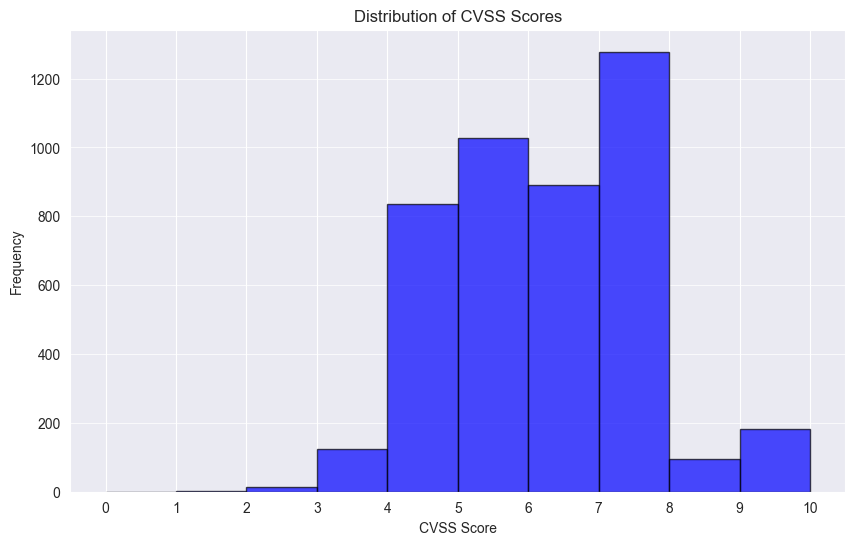

In [20]:
# Plot the distribution of CVSS scores
plt.figure(figsize=(10, 6))
plt.hist(cvss_scores_cleaned, bins=range(0, 11), alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of CVSS Scores')
plt.xlabel('CVSS Score')
plt.ylabel('Frequency')
plt.xticks(range(0, 11))
plt.grid(axis='y', alpha=0.75)
plt.show()

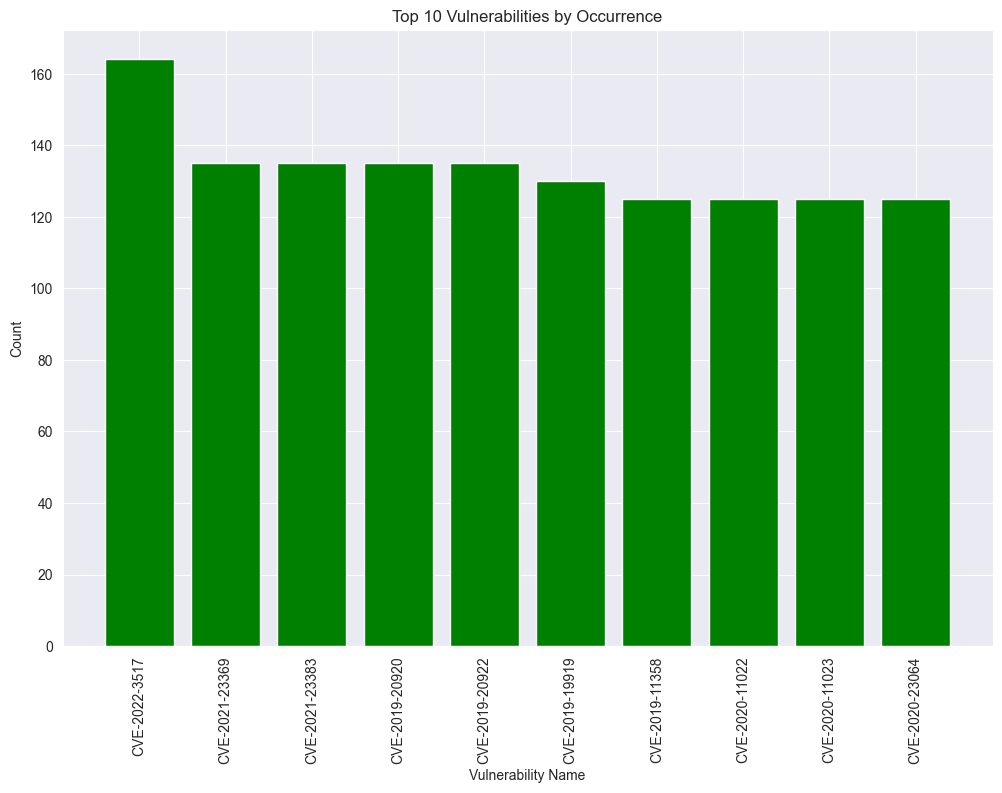

In [21]:
# Plot the distribution of the top N vulnerability names
N = 10  # Number of top vulnerabilities to display
top_vulnerabilities = Counter(vulnerability_names_step5).most_common(N)

# Names and counts
names, counts = zip(*top_vulnerabilities)

plt.figure(figsize=(12, 8))
plt.bar(names, counts, color='green')
plt.title(f'Top {N} Vulnerabilities by Occurrence')
plt.xlabel('Vulnerability Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

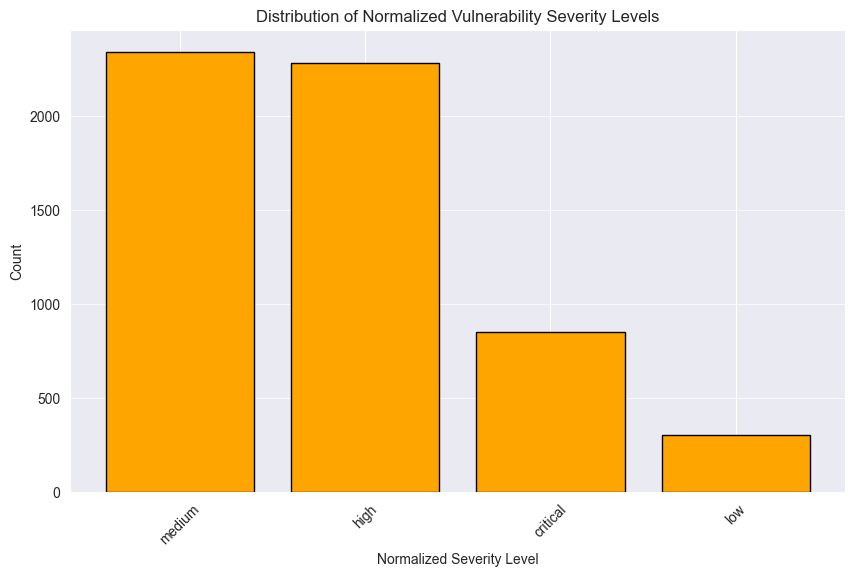

In [22]:
# Plot the distribution of normalized severity levels
plt.figure(figsize=(10, 6))
plt.bar(severity_counts.keys(), severity_counts.values(), color='orange', edgecolor='black')
plt.title('Distribution of Normalized Vulnerability Severity Levels')
plt.xlabel('Normalized Severity Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# Let's start by loading the data from the provided JSON files and creating the visualizations.

# Loading the data from step5 and step6 JSON files
step5_output = load_json_data('/mnt/data/step5_output.json')
step6_output = load_json_data('/mnt/data/step6_output.json')

# Visualization 1: Histogram of CVSS Scores
plot_cvss_histogram(step5_output)

# Visualization 2: Dependency Type Proportions
dependency_types = calculate_dependency_proportions(step6_output)

# Plotting the bar chart for dependency types
dependency_types.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Proportion of Dependency Types')
plt.xlabel('Dependency Type')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 3: Vulnerability Exposure vs. Dependency Type
# Extracting data for the scatter plot
vuln_exposure_data = {
    'dependency': [],
    'exposure_count': [],
    'avg_cvss_score': []
}

for dep, info in step6_output['dependencies'].items():
    vuln_exposure_data['dependency'].append(dep)
    vuln_exposure_data['exposure_count'].append(step6_output['vulnerabilityExposure'].get(dep, 0))
    vuln_exposure_data['avg_cvss_score'].append(info.get('highestCvssScore', 0))

# Creating a dataframe for visualization
vuln_exposure_df = pd.DataFrame(vuln_exposure_data)

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(vuln_exposure_df['exposure_count'], vuln_exposure_df['avg_cvss_score'], alpha=0.6, color='tomato')
plt.xscale('log')
plt.yscale('linear')
plt.title('Vulnerability Exposure vs. Average CVSS Score')
plt.xlabel('Exposure Count (log scale)')
plt.ylabel('Average CVSS Score')
plt.grid(True)
plt.show()

# Visualization 4: Update Frequency Analysis
# Extracting release intervals
release_intervals = [info['intervals'] for info in step6_output['dependencies'].values() if info['intervals'] != -1]

# Creating a histogram for release intervals
plt.figure(figsize=(10, 6))
plt.hist(release_intervals, bins=30, color='green', edgecolor='black')
plt.title('Distribution of Release Intervals')
plt.xlabel('Release Intervals (days)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
